Results Section

- Dipole Auger + 2MRS Dipoles in >cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------

- Dipole Auger + 2MRS Dipoles in slices of cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------
- Galaxy-Flux correlation for different cz
- [Use sample with completeness]
---------------------

- G-F correlation at closest cz for different K
- [Use sample with completeness]



### Read Full Catalogue

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


# Load Data
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
df = read_GLADE(cols)

# Redshift distribution
def plot_redshift_distribution(df):
    plt.figure()
    df['z_cmb'].hist(bins=50)
    plt.xlabel("z_cmb")
    plt.ylabel("Number of galaxies")
    plt.title("Redshift distribution")
    plt.show()

### Plot K vs d_L
def plot_MK_vs_dL(df):
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        df["d_L"],
        df["M_K"],
        bins=80,
        cmap='Blues',
        norm=LogNorm()
    )
    # Reference lines
    plt.axvline(x=100, color='k', linestyle='dashed')
    plt.axvline(x=200, color='k', linestyle='dashed')
    plt.axhline(-21, color='k', linestyle='dashed')
    plt.axhline(-22.4, color='k', linestyle='dashed')
    # Labels and style
    plt.xlabel("Luminosity distance $d_L$ [Mpc]")
    plt.ylabel("Absolute magnitude $M_K$")
    #plt.title("Absolute K-band magnitude vs. luminosity distance")
    plt.gca().invert_yaxis()  # brighter = up
    # Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of galaxies")
    plt.tight_layout()
    plt.show()

### Plot K vs cz
def plot_MK_vs_cz(df):
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        df["cz"],
        df["M_K"],
        bins=80,
        cmap='Blues',
        norm=LogNorm()
    )
    # Reference lines
    #plt.axvline(x=100, color='k', linestyle='dashed')
    #plt.axvline(x=200, color='k', linestyle='dashed')
    plt.axhline(-21, color='k', linestyle='dashed')
    plt.axhline(-22.4, color='k', linestyle='dashed')
    # Labels and style
    plt.xlabel("cz [km/s]")
    plt.ylabel("Absolute magnitude $M_K$")
    #plt.title("Absolute K-band magnitude vs. luminosity distance")
    plt.gca().invert_yaxis()  # brighter = up
    # Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of galaxies")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_5357/1206302531.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 144134


Number of galaxies: 144134


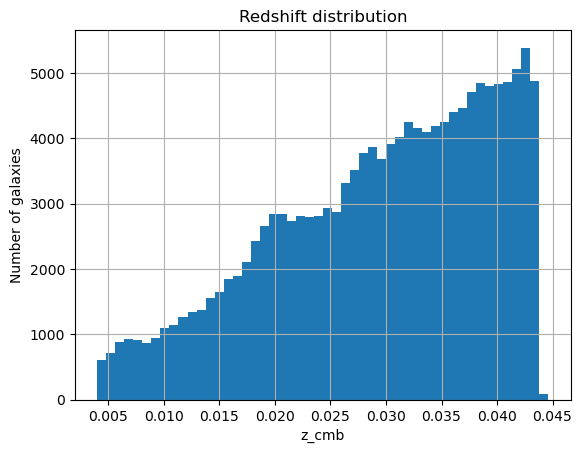

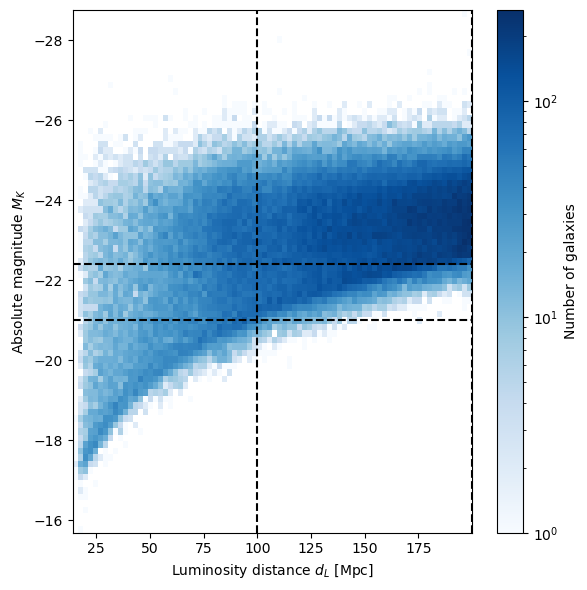

In [3]:

# ----------------------------
# INSPECT DATA
# ----------------------------
print("Number of galaxies:", len(df))


plot_redshift_distribution(df)
plot_MK_vs_dL(df)

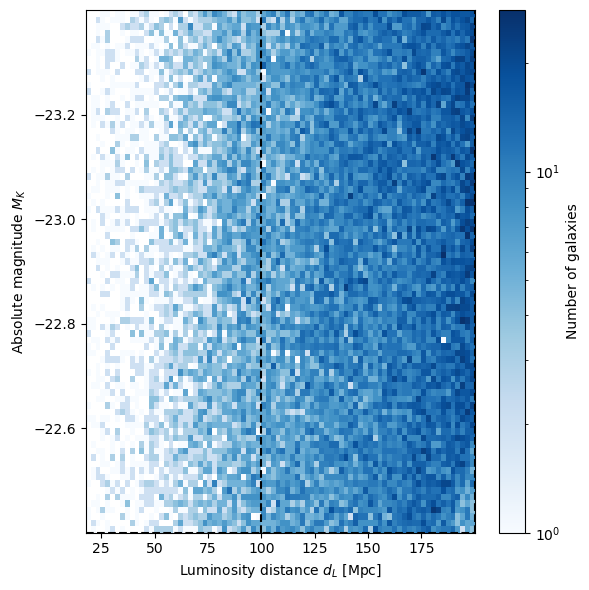

In [4]:
df_K = df[df["M_K"]<-22.4]
df_K = df_K[df_K["M_K"]>-23.4]

# Plot
plot_MK_vs_dL(df_K)


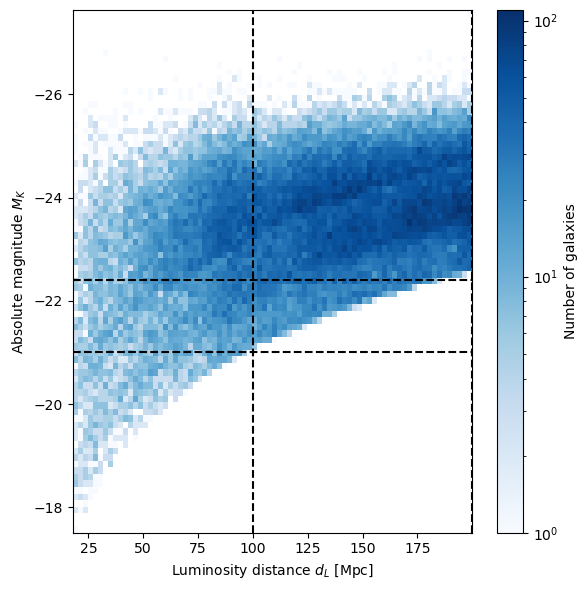


=== Dipole for Full Sample ===
N = 63636 galaxies
RA = 172.11° ± 2.90° (± 2.79° bootstrapped)
Dec = -1.82° ± 2.90° (± 2.73° bootstrapped)
Amplitude = 0.0641 ± 0.0034
Significance = inf sigma (p = 8.91e-86)
Angular separation from Auger = 72.94° ± 2.85°

=== Dipole for 1000-1500 km/s ===
N = 320 galaxies
RA = 177.47° ± 11.79° (± 9.15° bootstrapped)
Dec = 15.41° ± 11.79° (± 9.22° bootstrapped)
Amplitude = 0.3482 ± 0.0791
Significance = 4.33 sigma (p = 7.51e-06)
Angular separation from Auger = 85.24° ± 9.86°

=== Dipole for 1500-2000 km/s ===
N = 855 galaxies
RA = 98.58° ± 10.84° (± 13.29° bootstrapped)
Dec = -47.07° ± 10.84° (± 6.01° bootstrapped)
Amplitude = 0.2836 ± 0.0380
Significance = 4.78 sigma (p = 8.57e-07)
Angular separation from Auger = 23.10° ± 5.73°

=== Dipole for 2000-2500 km/s ===
N = 917 galaxies
RA = 156.57° ± 6.87° (± 7.41° bootstrapped)
Dec = -18.57° ± 6.87° (± 6.93° bootstrapped)
Amplitude = 0.3444 ± 0.0340
Significance = 7.97 sigma (p = 7.69e-16)
Angular separation 

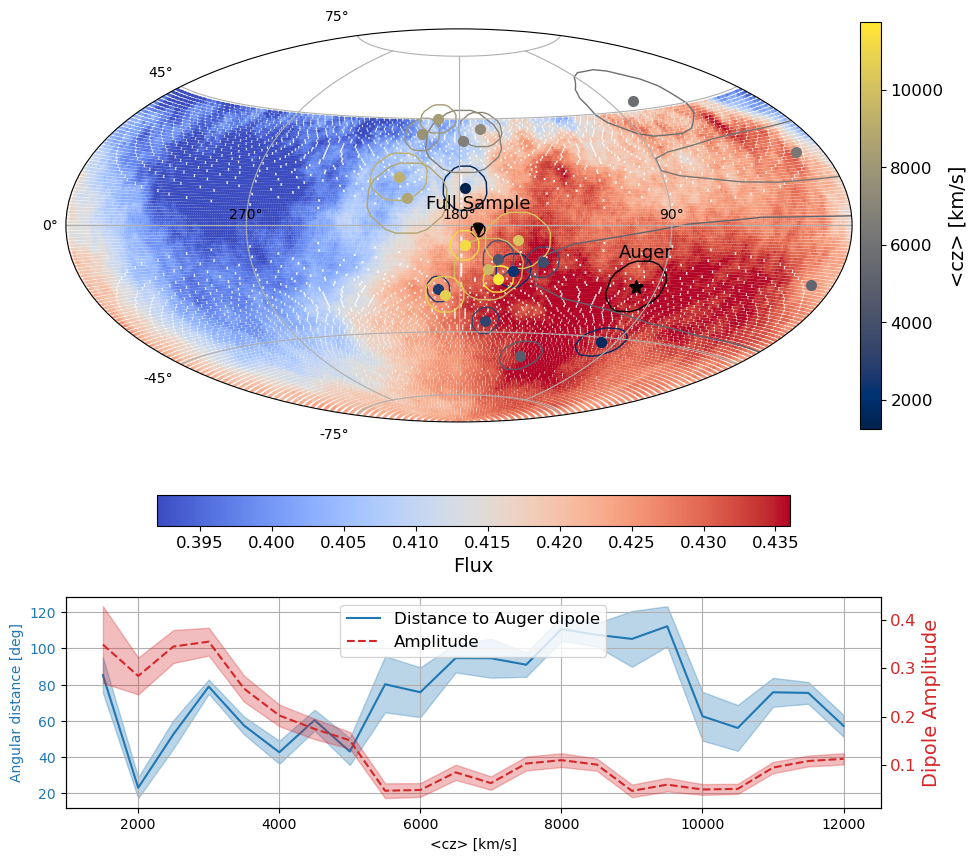

In [5]:

def dipoles_plot(df, plotname, mag_z_plot=True):

    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import Planck18
    from matplotlib.patches import Ellipse
    import matplotlib.colors as colors
    from matplotlib.cm import ScalarMappable

    if mag_z_plot: plot_MK_vs_dL(df)

    RA_all = np.deg2rad(df['RA'])
    Dec_all = np.deg2rad(df['Dec'])
    cz_all = df['cz']
    #weights_all = np.ones(len(RA_all))
    weights_all = 10**(-.4 * df['M_K']) # Use K-band Luminosity as weights

    # === Load flux cataloge ===
    # Load flux data
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)

    # Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    # Convert to radians
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)

    # Shift RA to put RA=0° on right edge, increase leftward
    ra_shifted = np.remainder(ra_rad + np.pi, 2 * np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2 * np.pi
    ra_shifted = -ra_shifted  # flip to increase leftward


    # === Define cz bins ===
    # cz_bins = [
    #     (1200, 9000),       # Full sample
    #     (1200, 3600),
    #     (4000, 5000),
    #     (9000, 9400)
    # ]
    cz_bins = [(cz, cz + 500) for cz in range(1000, 12000, 500)]
    cz_bins.insert(0, (1000, 12000))  # Add full sample as first bin

    # === Setup colors and storage ===
    #n_bins = len(cz_bins)
    dipole_results = {}
    # Normalize cz range for colormap
    cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
    cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
    cmap = cm.cividis  # or try 'viridis', 'turbo', 'cividis'
    #import seaborn as sns
    #cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

    # === Auger reference dipole ===
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    #auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction
    auger_error_ra_deg = 10.0  # Uncertainty in RA
    auger_error_dec_deg = 13.0  # Uncertainty in Dec

    # === Loop through bins ===
    for i, (cz_min, cz_max) in enumerate(cz_bins):
        label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
        cz_mid = 0.5 * (cz_min + cz_max)
        color = 'k' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

        # Filter galaxies
        mask = (cz_all > cz_min) & (cz_all < cz_max)
        RA = np.array(RA_all[mask])
        Dec = np.array(Dec_all[mask])
        weights = np.array(weights_all[mask])

        if len(RA) < 10:
            print(f"Skipping {label} — too few galaxies ({len(RA)})")
            continue

        W = np.sum(weights)

        # === 2D Rayleigh dipole ===
        a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
        b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
        r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
        #phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

        # === 3D dipole direction ===
        x = np.cos(Dec) * np.cos(RA)
        y = np.cos(Dec) * np.sin(RA)
        z = np.sin(Dec)
        X = np.sum(weights * x)
        Y = np.sum(weights * y)
        Z = np.sum(weights * z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        X /= norm
        Y /= norm
        Z /= norm

        dipole_amp = norm / W
        alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
        delta_d = np.arcsin(Z) * 180 / np.pi

        # === Uncertainty and significance ===
        Weff = W**2 / np.sum(weights**2)                # Effective weight
        sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
        sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
        sigma_dec_deg = sigma_phi_deg                   # rough approximation
        P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
        Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

        # === Angular separation from Auger dipole ===
        dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
        separation = dip_coord.separation(auger_coord).deg

        # === Store results ===
        dipole_results[label] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'r_alpha': r_alpha,
            'd_perp': dipole_amp,
            'sigma_r': sigma_r,
            'sigma_phi': sigma_phi_deg,
            'sigma_dec': sigma_dec_deg,
            'Z': Zsig,
            'P': P_rayleigh,
            'separation': separation,
            'N': len(RA),
            'color': color
        }

        # === Bootstrap dipole errors ===
        n_bootstrap = 500
        dipole_ras = []
        dipole_decs = []
        dipole_amps_bs = []
        sep_bs = []

        for _ in range(n_bootstrap):
            indices = np.random.choice(len(RA), size=len(RA), replace=True)
            RA_bs = RA[indices]
            Dec_bs = Dec[indices]
            weights_bs = weights[indices]


            x = np.cos(Dec_bs) * np.cos(RA_bs)
            y = np.cos(Dec_bs) * np.sin(RA_bs)
            z = np.sin(Dec_bs)

            X = np.sum(weights_bs * x)
            Y = np.sum(weights_bs * y)
            Z = np.sum(weights_bs * z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X /= norm
            Y /= norm
            Z /= norm

            amp = norm / np.sum(weights_bs)
            ra_bs = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
            dec_bs = np.arcsin(Z) * 180 / np.pi

            dipole_ras.append(ra_bs)
            dipole_decs.append(dec_bs)
            dipole_amps_bs.append(amp)

            # Angular separation with Auger dipole
            dip_coord_bs = SkyCoord(ra=ra_bs * u.deg, dec=dec_bs * u.deg, frame='icrs')
            sep = dip_coord_bs.separation(auger_coord).deg
            sep_bs.append(sep)

        # === Bootstrap uncertainties ===
        sigma_ra_boot = np.std(dipole_ras)
        sigma_dec_boot = np.std(dipole_decs)
        sigma_amp_boot = np.std(dipole_amps_bs)
        sigma_sep_boot = np.std(sep_bs)

        dipole_results[label].update({
            'sigma_ra_boot': sigma_ra_boot,
            'sigma_dec_boot': sigma_dec_boot,
            'sigma_amp_boot': sigma_amp_boot,
            'sigma_sep_boot': sigma_sep_boot
        })

        # === Print result ===
        print(f"\n=== Dipole for {label} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}° (± {sigma_ra_boot:.2f}° bootstrapped)")
        print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}° (± {sigma_dec_boot:.2f}° bootstrapped)")
        print(f"Amplitude = {dipole_amp:.4f} ± {sigma_amp_boot:.4f}")
        print(f"Significance = {Zsig:.2f} sigma (p = {P_rayleigh:.2e})")
        print(f"Angular separation from Auger = {separation:.2f}° ± {sigma_sep_boot:.2f}°")


    # === Set up top and bottom subplots ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    # === Set fontsizrs ===

    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    # === Configure Hammer (Top) Axis ===
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Plot flux on sky ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    # === Remove NaNs from flux_val and corresponding positions ===
    mask = np.isfinite(flux_val)
    ra_shifted = ra_shifted[mask]
    dec_rad = np.radians(flux_dec[mask])
    flux_val = flux_val[mask]
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for flux
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=-.1, fraction=0.05)
    cbar_flux.set_label("Flux")

    # === Plot dipoles ===
    for label, res in dipole_results.items():
        ra_rad = np.deg2rad(res['RA'])
        dec_rad = np.deg2rad(res['Dec'])
        ra_plot = -ra_rad + np.pi  # <- RA increases right to left
        color = res['color']
        amp = res['d_perp']

        marker = 'o' if label != 'Full Sample' else 'v'
        ax_top.plot(ra_plot, dec_rad, marker, color=color, label=label, markersize=7)

        ellipse = Ellipse(
            (ra_plot, dec_rad),
            width=2*np.deg2rad(res['sigma_ra_boot']),
            height=2*np.deg2rad(res['sigma_dec_boot']),
            angle=0,
            edgecolor=color,
            facecolor='none',
            alpha=1,
            transform=ax_top.transData
        )
        ax_top.add_patch(ellipse)

        if label == 'Full Sample':
            ax_top.text(ra_plot, dec_rad + 0.15, label, ha='center', color='k', size=13)

    # Auger point and ellipse
    auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
    auger_dec_rad = np.deg2rad(auger_Dec)
    ax_top.plot(auger_ra_plot, auger_dec_rad, 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (auger_ra_plot, auger_dec_rad),
        width=2*np.deg2rad(auger_error_dec_deg),
        height=2*np.deg2rad(auger_error_ra_deg),
        angle=0,
        edgecolor='k',
        facecolor='none',
        alpha=1,
        transform=ax_top.transData
    )
    ax_top.add_patch(ellipse)
    ax_top.text(auger_ra_plot, auger_dec_rad + 0.2, "Auger", ha='center', color='k', size=13)
    #ax_top.set_title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)

    # Vertical cz colorbar
    sm = ScalarMappable(cmap=cmap, norm=cz_norm)
    sm.set_array([])
    cbar_cz = fig.colorbar(sm, ax=ax_top, orientation='vertical', pad=0.01, fraction=0.025)
    cbar_cz.set_label("<cz> [km/s]")

    # === Bottom Plot: Dipole amp & separation ===
    cz_bin_centers = []
    angular_separations = []
    dipole_amps = []
    ang_diam_dists = []

    for label, res in dipole_results.items():
        if label == "Full Sample":
            continue

        cz_mid = float(label.split('-')[0]) + 500
        cz_bin_centers.append(cz_mid)
        angular_separations.append(res['separation'])
        dipole_amps.append(res['d_perp'])

        cosmo = Planck18
        z = cz_mid / 3e5
        d_ang = cosmo.angular_diameter_distance(z).value
        ang_diam_dists.append(d_ang)

    x = cz_bin_centers
    sep_errors = [dipole_results[label]['sigma_sep_boot'] for label in dipole_results if label != "Full Sample"]
    amp_errors = [dipole_results[label]['sigma_amp_boot'] for label in dipole_results if label != "Full Sample"]

    # Angular separation on left y-axis
    color1 = 'C0'
    ax_bottom.fill_between(x, np.array(angular_separations)-np.array(sep_errors), np.array(angular_separations)+np.array(sep_errors), color=color1, alpha=0.3)
    ln1 = ax_bottom.plot(x, angular_separations, ls='-', color=color1, label='Distance to Auger dipole')
    ax_bottom.set_ylabel("Angular distance [deg]", color=color1)
    ax_bottom.tick_params(axis='y', labelcolor=color1)
    ax_bottom.grid(True)

    # Dipole amplitude on right y-axis
    ax2 = ax_bottom.twinx()
    color2 = 'C3'
    ax2.fill_between(x, np.array(dipole_amps)-np.array(amp_errors), np.array(dipole_amps)+np.array(amp_errors), color=color2, alpha=0.3)
    ln2 = ax2.plot(x, dipole_amps, ls='--', color=color2, label='Amplitude')
    ax2.set_ylabel("Dipole Amplitude", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # X-axis
    ax_bottom.set_xlabel("<cz> [km/s]")

    # Legend
    lines = ln1 + ln2  # flatten the list of lines
    labels = [l.get_label() for l in lines]
    ax_bottom.legend(lines, labels, loc='upper center')


    #ax_bottom.set_title("Dipole Angular Separation and Amplitude vs cz")
    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        #'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()


df_K_spec = df_K[df_K['dist_flag'] == 3]
df_spec = df[df['dist_flag'] == 3]

dipoles_plot(df_spec, plotname='../plots/plot1_GLADEspec_paper1.png')


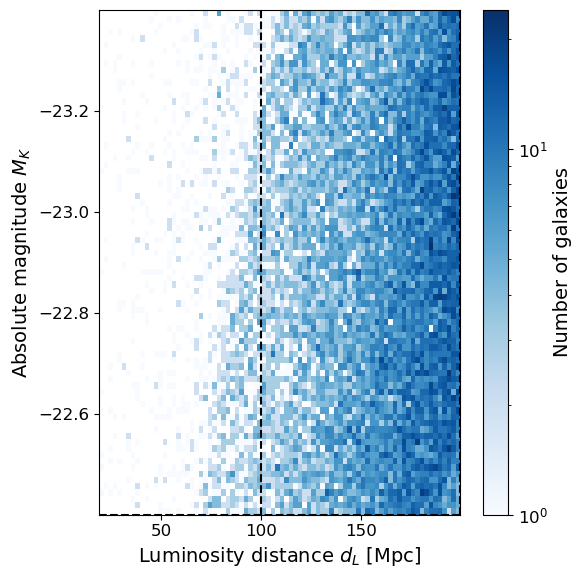


=== Dipole for Full Sample ===
N = 17787 galaxies
RA = 35.58° ± 1.46° (± 1.43° bootstrapped)
Dec = 45.21° ± 1.46° (± 0.82° bootstrapped)
Amplitude = 0.2544 ± 0.0045
Significance = inf sigma (p = 0.00e+00)
Angular separation from Auger = 90.62° ± 1.04°
Skipping 1000-1500 km/s — too few galaxies (8)

=== Dipole for 1500-2000 km/s ===
N = 29 galaxies
RA = 191.03° ± 35.15° (± 28.95° bootstrapped)
Dec = 4.74° ± 35.15° (± 22.70° bootstrapped)
Amplitude = 0.2582 ± 0.1041
Significance = 0.63 sigma (p = 2.65e-01)
Angular separation from Auger = 92.86° ± 22.84°

=== Dipole for 2000-2500 km/s ===
N = 39 galaxies
RA = 122.25° ± 17.01° (± 14.93° bootstrapped)
Dec = -10.53° ± 17.01° (± 15.39° bootstrapped)
Amplitude = 0.3539 ± 0.0831
Significance = 2.70 sigma (p = 3.44e-03)
Angular separation from Auger = 25.09° ± 11.92°

=== Dipole for 2500-3000 km/s ===
N = 46 galaxies
RA = 105.99° ± 14.78° (± 12.00° bootstrapped)
Dec = 26.93° ± 14.78° (± 13.35° bootstrapped)
Amplitude = 0.3883 ± 0.0828
Significa

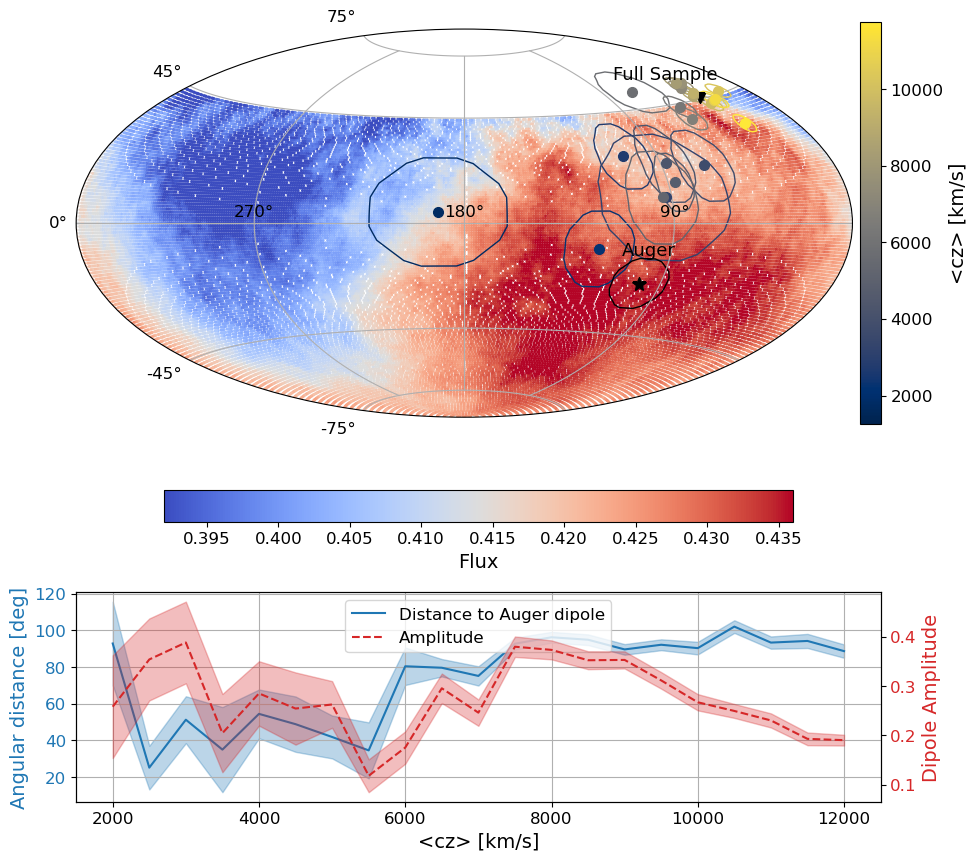

In [6]:
df_K_phot = df_K[df_K['dist_flag'] == 1]

dipoles_plot(df_K_phot, plotname='../plots/plot1_GLADEphot_paper1.png')

### Modified plot to show only 3 dipoles

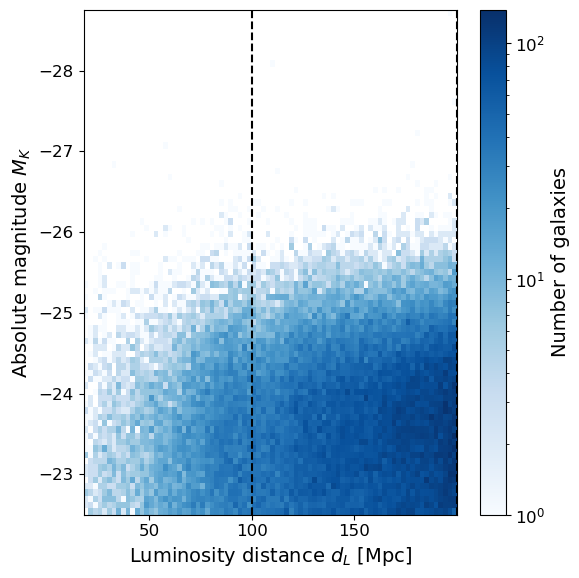

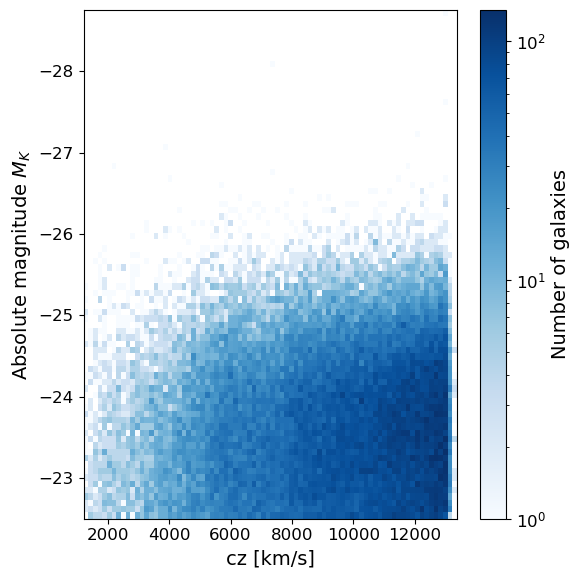


=== Dipole for Full Sample ===
N = 78919 galaxies
RA = 104.00° ± 5.16° (± 5.49° bootstrapped)
Dec = 50.97° ± 5.16° (± 2.99° bootstrapped)
Amplitude = 0.0498 ± 0.0024
Significance = inf sigma (p = 1.55e-27)
Angular separation from Auger = 75.05° ± 3.03°

=== Dipole for 1500-2000 km/s ===
N = 327 galaxies
RA = 100.14° ± 12.41° (± 15.86° bootstrapped)
Dec = -48.40° ± 12.41° (± 6.58° bootstrapped)
Amplitude = 0.2712 ± 0.0431
Significance = 4.07 sigma (p = 2.35e-05)
Angular separation from Auger = 24.40° ± 6.42°

=== Dipole for 2000-2500 km/s ===
N = 427 galaxies
RA = 156.40° ± 7.13° (± 7.71° bootstrapped)
Dec = -18.45° ± 7.13° (± 7.05° bootstrapped)
Amplitude = 0.3453 ± 0.0342
Significance = 7.66 sigma (p = 9.52e-15)
Angular separation from Auger = 52.53° ± 7.89°

=== Dipole for 2500-3000 km/s ===
N = 511 galaxies
RA = 188.40° ± 5.83° (± 5.02° bootstrapped)
Dec = -25.15° ± 5.83° (± 6.43° bootstrapped)
Amplitude = 0.3506 ± 0.0304
Significance = inf sigma (p = 1.03e-21)
Angular separation f

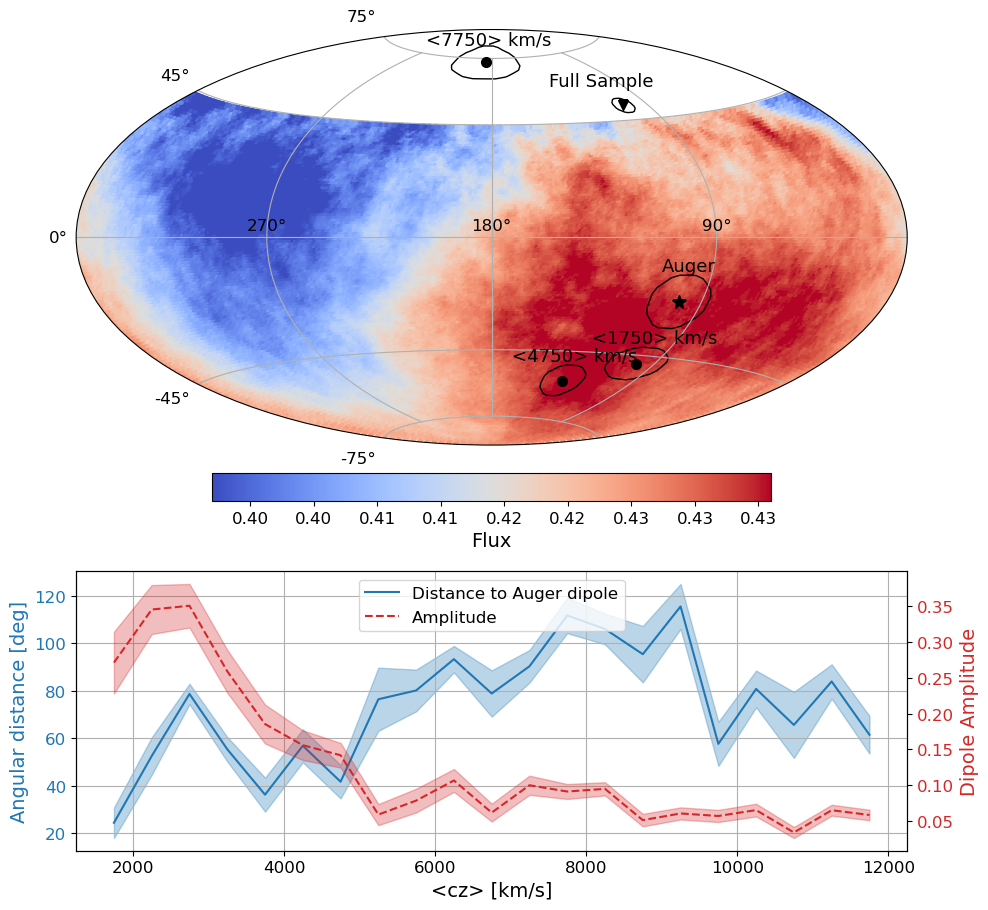

In [5]:

def dipoles_plot(df, plotname, mag_z_plot=True):

    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import Planck18
    cosmo = Planck18
    from matplotlib.patches import Ellipse
    import matplotlib.colors as colors
    from matplotlib.cm import ScalarMappable
    from matplotlib.ticker import FormatStrFormatter

    if mag_z_plot: 
        plot_MK_vs_dL(df)
        plot_MK_vs_cz(df)

    RA_all = np.deg2rad(df['RA'])
    Dec_all = np.deg2rad(df['Dec'])
    cz_all = df['cz']
    #weights_all = np.ones(len(RA_all))
    weights_all = 10**(-.4 * df['M_K']) # Use K-band Luminosity as weights

    # === Load flux cataloge ===
    # Load flux data
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)

    # Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    # Convert to radians
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)

    # Shift RA to put RA=0° on right edge, increase leftward
    ra_shifted = np.remainder(ra_rad + np.pi, 2 * np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2 * np.pi
    ra_shifted = -ra_shifted  # flip to increase leftward


    # === Define cz bins ===
    cz_i, cz_f, cz_step = 1500, 12000, 500
    cz_bins = [(cz, cz + 500) for cz in range(cz_i, cz_f, cz_step)]
    cz_bins.insert(0, (cz_i, cz_f))  # Add full sample as first bin

    # === Setup colors and storage ===
    #n_bins = len(cz_bins)
    dipole_results = {}
    # Normalize cz range for colormap
    cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
    cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
    cmap = cm.cividis  # or try 'viridis', 'turbo', 'cividis'
    #import seaborn as sns
    #cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

    # === Auger reference dipole ===
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    #auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction
    auger_error_ra_deg = 10.0  # Uncertainty in RA
    auger_error_dec_deg = 13.0  # Uncertainty in Dec

    # === Loop through bins ===
    for i, (cz_min, cz_max) in enumerate(cz_bins):
        label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
        cz_mid = 0.5 * (cz_min + cz_max)
        color = 'k' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

        # Filter galaxies
        mask = (cz_all > cz_min) & (cz_all < cz_max)
        RA = np.array(RA_all[mask])
        Dec = np.array(Dec_all[mask])
        weights = np.array(weights_all[mask])

        if len(RA) < 10:
            print(f"Skipping {label} — too few galaxies ({len(RA)})")
            continue

        W = np.sum(weights)

        # === 2D Rayleigh dipole ===
        a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
        b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
        r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
        #phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

        # === 3D dipole direction ===
        x = np.cos(Dec) * np.cos(RA)
        y = np.cos(Dec) * np.sin(RA)
        z = np.sin(Dec)
        X = np.sum(weights * x)
        Y = np.sum(weights * y)
        Z = np.sum(weights * z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        X /= norm
        Y /= norm
        Z /= norm

        dipole_amp = norm / W
        alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
        delta_d = np.arcsin(Z) * 180 / np.pi

        # === Uncertainty and significance ===
        Weff = W**2 / np.sum(weights**2)                # Effective weight
        sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
        sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
        sigma_dec_deg = sigma_phi_deg                   # rough approximation
        P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
        Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

        # === Angular separation from Auger dipole ===
        dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
        separation = dip_coord.separation(auger_coord).deg

        # === Store results ===
        dipole_results[label] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'r_alpha': r_alpha,
            'd_perp': dipole_amp,
            'sigma_r': sigma_r,
            'sigma_phi': sigma_phi_deg,
            'sigma_dec': sigma_dec_deg,
            'Z': Zsig,
            'P': P_rayleigh,
            'separation': separation,
            'N': len(RA),
            'color': color
        }

        # === Bootstrap dipole errors ===
        n_bootstrap = 500
        dipole_ras = []
        dipole_decs = []
        dipole_amps_bs = []
        sep_bs = []

        for _ in range(n_bootstrap):
            indices = np.random.choice(len(RA), size=len(RA), replace=True)
            RA_bs = RA[indices]
            Dec_bs = Dec[indices]
            weights_bs = weights[indices]


            x = np.cos(Dec_bs) * np.cos(RA_bs)
            y = np.cos(Dec_bs) * np.sin(RA_bs)
            z = np.sin(Dec_bs)

            X = np.sum(weights_bs * x)
            Y = np.sum(weights_bs * y)
            Z = np.sum(weights_bs * z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X /= norm
            Y /= norm
            Z /= norm

            amp = norm / np.sum(weights_bs)
            ra_bs = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
            dec_bs = np.arcsin(Z) * 180 / np.pi

            dipole_ras.append(ra_bs)
            dipole_decs.append(dec_bs)
            dipole_amps_bs.append(amp)

            # Angular separation with Auger dipole
            dip_coord_bs = SkyCoord(ra=ra_bs * u.deg, dec=dec_bs * u.deg, frame='icrs')
            sep = dip_coord_bs.separation(auger_coord).deg
            sep_bs.append(sep)

        # === Bootstrap uncertainties ===
        sigma_ra_boot = np.std(dipole_ras)
        sigma_dec_boot = np.std(dipole_decs)
        sigma_amp_boot = np.std(dipole_amps_bs)
        sigma_sep_boot = np.std(sep_bs)

        dipole_results[label].update({
            'sigma_ra_boot': sigma_ra_boot,
            'sigma_dec_boot': sigma_dec_boot,
            'sigma_amp_boot': sigma_amp_boot,
            'sigma_sep_boot': sigma_sep_boot
        })

        # === Print result ===
        print(f"\n=== Dipole for {label} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}° (± {sigma_ra_boot:.2f}° bootstrapped)")
        print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}° (± {sigma_dec_boot:.2f}° bootstrapped)")
        print(f"Amplitude = {dipole_amp:.4f} ± {sigma_amp_boot:.4f}")
        print(f"Significance = {Zsig:.2f} sigma (p = {P_rayleigh:.2e})")
        print(f"Angular separation from Auger = {separation:.2f}° ± {sigma_sep_boot:.2f}°")


    # === Set up top and bottom subplots ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    # === Set fontsizrs ===

    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    # === Configure Hammer (Top) Axis ===
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Plot flux on sky ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    # === Remove NaNs from flux_val and corresponding positions ===
    mask = np.isfinite(flux_val)
    ra_shifted = ra_shifted[mask]
    dec_rad = np.radians(flux_dec[mask])
    flux_val = flux_val[mask]
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=15, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for flux
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=.05, fraction=0.05)
    cbar_flux.set_label("Flux")
    cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # === Plot dipoles ===
    for label, res in dipole_results.items():
        
        if label not in [f"{cz_min}-{cz_max} km/s" for cz_min, cz_max in [(1500, 2000), (4500, 5000), (7500, 8000)]] + ['Full Sample']:
            continue

        ra_rad = np.deg2rad(res['RA'])
        dec_rad = np.deg2rad(res['Dec'])
        ra_plot = -ra_rad + np.pi  # <- RA increases right to left
        color = res['color']
        amp = res['d_perp']

        marker = 'o' if label != 'Full Sample' else 'v'
        ax_top.plot(ra_plot, dec_rad, marker, color='k', label=label, markersize=7)

        ellipse = Ellipse(
            (ra_plot, dec_rad),
            width=2*np.deg2rad(res['sigma_ra_boot']),
            height=2*np.deg2rad(res['sigma_dec_boot']),
            angle=0,
            edgecolor='k',
            facecolor='none',
            alpha=1,
            transform=ax_top.transData
        )
        ax_top.add_patch(ellipse)

        #if label == 'Full Sample':
        czmid = float(label.split('-')[0]) + 250 if label != 'Full Sample' else label
        ax_top.text(ra_plot, dec_rad + 0.15, f'<{int(czmid)}> km/s' if czmid!='Full Sample' else 'Full Sample'\
                    , ha='center', color='k', size=13)

    # Auger point and ellipse
    auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
    auger_dec_rad = np.deg2rad(auger_Dec)
    ax_top.plot(auger_ra_plot, auger_dec_rad, 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (auger_ra_plot, auger_dec_rad),
        width=2*np.deg2rad(auger_error_dec_deg),
        height=2*np.deg2rad(auger_error_ra_deg),
        angle=0,
        edgecolor='k',
        facecolor='none',
        alpha=1,
        transform=ax_top.transData
    )
    ax_top.add_patch(ellipse)
    ax_top.text(auger_ra_plot, auger_dec_rad + 0.2, "Auger", ha='center', color='k', size=13)
    #ax_top.set_title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)

    # # Vertical cz colorbar
    # sm = ScalarMappable(cmap=cmap, norm=cz_norm)
    # sm.set_array([])
    # cbar_cz = fig.colorbar(sm, ax=ax_top, orientation='vertical', pad=0.01, fraction=0.025)
    # cbar_cz.set_label("<cz> [km/s]")

    # === Bottom Plot: Dipole amp & separation ===
    cz_bin_centers = []
    angular_separations = []
    dipole_amps = []
    ang_diam_dists = []

    for label, res in dipole_results.items():
        if label == "Full Sample":
            continue

        cz_mid = float(label.split('-')[0]) + cz_step/2
        cz_bin_centers.append(cz_mid)
        angular_separations.append(res['separation'])
        dipole_amps.append(res['d_perp'])

        cosmo = Planck18
        z = cz_mid / 3e5
        d_ang = cosmo.angular_diameter_distance(z).value
        ang_diam_dists.append(d_ang)

    x = cz_bin_centers
    sep_errors = [dipole_results[label]['sigma_sep_boot'] for label in dipole_results if label != "Full Sample"]
    amp_errors = [dipole_results[label]['sigma_amp_boot'] for label in dipole_results if label != "Full Sample"]

    # Angular separation on left y-axis
    color1 = 'C0'
    ax_bottom.fill_between(x, np.array(angular_separations)-np.array(sep_errors), np.array(angular_separations)+np.array(sep_errors), color=color1, alpha=0.3)
    ln1 = ax_bottom.plot(x, angular_separations, ls='-', color=color1, label='Distance to Auger dipole')
    ax_bottom.set_ylabel("Angular distance [deg]", color=color1)
    ax_bottom.tick_params(axis='y', labelcolor=color1)
    ax_bottom.grid(True)

    # Dipole amplitude on right y-axis
    ax2 = ax_bottom.twinx()
    color2 = 'C3'
    ax2.fill_between(x, np.array(dipole_amps)-np.array(amp_errors), np.array(dipole_amps)+np.array(amp_errors), color=color2, alpha=0.3)
    ln2 = ax2.plot(x, dipole_amps, ls='--', color=color2, label='Amplitude')
    ax2.set_ylabel("Dipole Amplitude", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # X-axis
    ax_bottom.set_xlabel("<cz> [km/s]")

    # Legend
    lines = ln1 + ln2  # flatten the list of lines
    labels = [l.get_label() for l in lines]
    ax_bottom.legend(lines, labels, loc='upper center')


    #ax_bottom.set_title("Dipole Angular Separation and Amplitude vs cz")
    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        #'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()


#df_K_spec = df_K[df_K['dist_flag'] == 3]
#df_spec = df[df['dist_flag'] == 3]

df_K = df[df['M_K']<-22.5]
df_K_dec = df_K[df_K['Dec']<45]
dipoles_plot(df_K, plotname='../plots/plot1_GLADE_paper1.png')


## LVGCatalogue

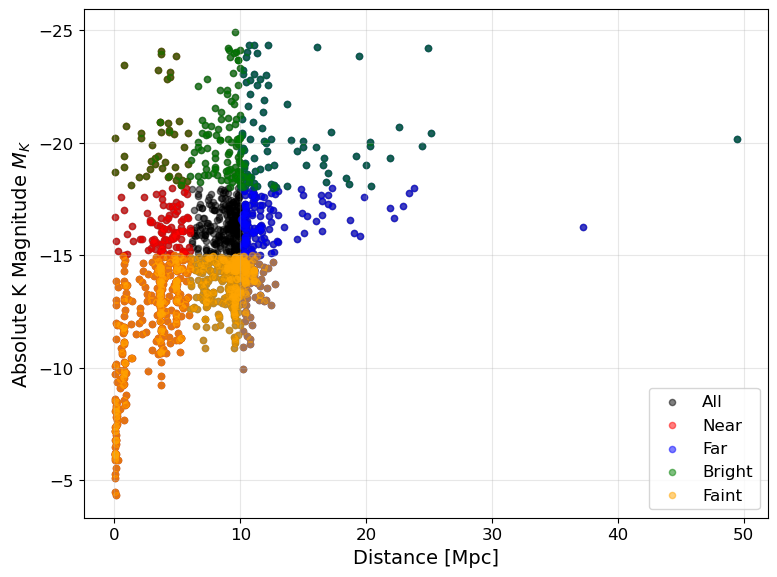

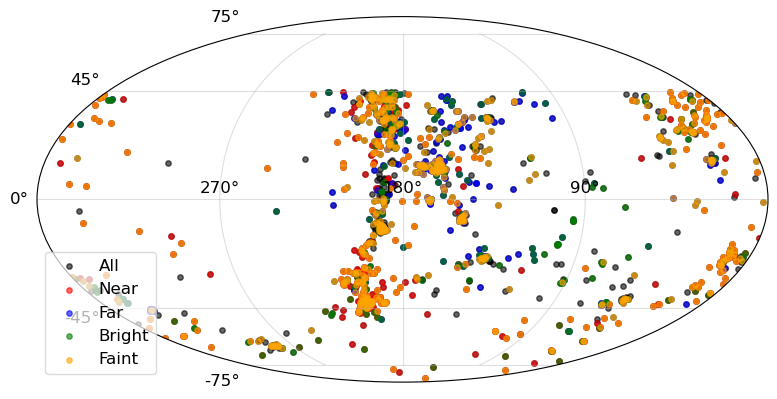


=== Dipole for All ===
N = 1296 galaxies
RA = 159.19 +/- 9.61 deg
Dec = -2.17 +/- 8.82 deg
d_perp = 0.4795 +/- 0.0828
Separation to Auger dipole = 61.12 +/- 9.28 deg


=== Dipole for Near ===
N = 409 galaxies
RA = 209.90 +/- 84.49 deg
Dec = -51.59 +/- 28.55 deg
d_perp = 0.3415 +/- 0.1718
Separation to Auger dipole = 82.79 +/- 10.66 deg


=== Dipole for Far ===
N = 322 galaxies
RA = 154.83 +/- 10.72 deg
Dec = 3.98 +/- 7.93 deg
d_perp = 0.6208 +/- 0.1098
Separation to Auger dipole = 60.22 +/- 11.88 deg


=== Dipole for Bright ===
N = 225 galaxies
RA = 151.98 +/- 5.38 deg
Dec = -1.15 +/- 5.54 deg
d_perp = 0.3780 +/- 0.0366
Separation to Auger dipole = 55.20 +/- 5.90 deg


=== Dipole for Faint ===
N = 585 galaxies
RA = 170.49 +/- 2.63 deg
Dec = -3.88 +/- 3.55 deg
d_perp = 0.3593 +/- 0.0277
Separation to Auger dipole = 70.61 +/- 2.59 deg



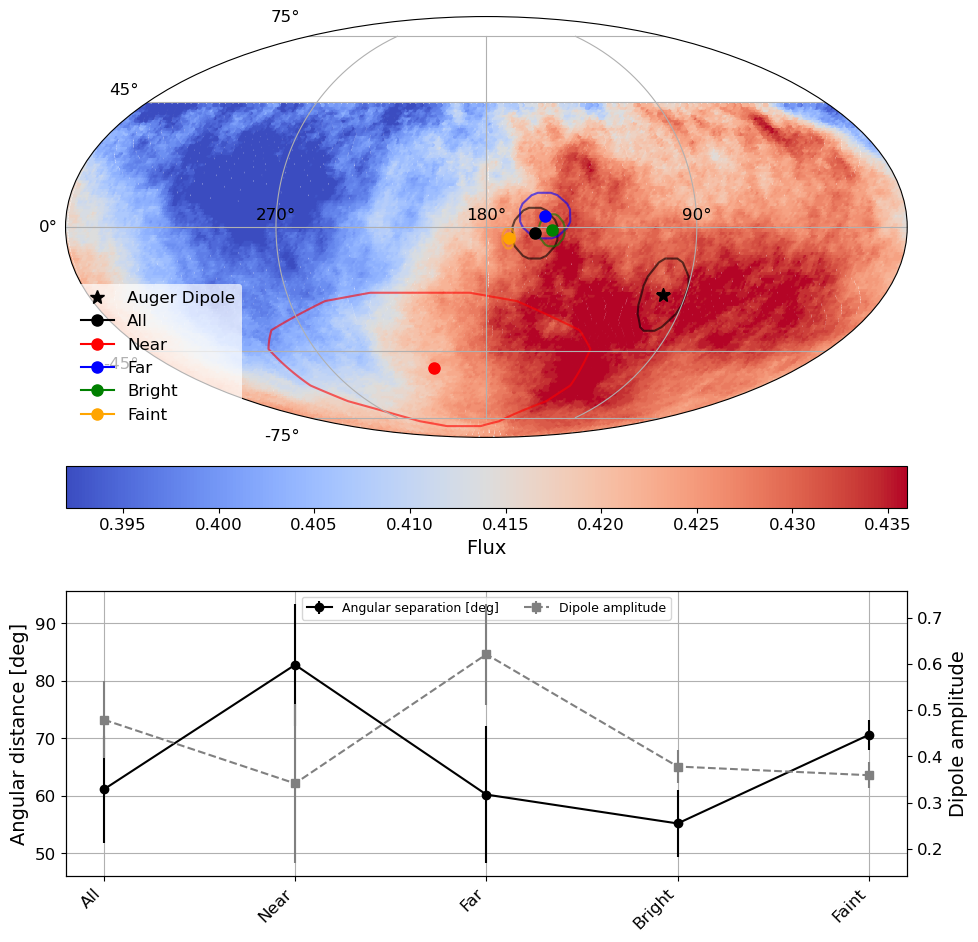

In [8]:
import pandas as pd
import numpy as np
import re
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

# ------------------------
# STEP 0: Read LVGC
# ------------------------
def read_LVGC(file="../data/lvg_table1.dat"):
    colnames = [
        "Name", "RAh", "RAm", "RAs", "DE_sign", "DEd", "DEm", "DEs",
        "a26", "b_a", "AB", "l_FUVmag", "FUVmag", "Bmag", "l_Hamag", 
        "Hamag", "Kmag", "f_Kmag", "l_21mag", "21mag", "W50", "TType",
        "Tdw1", "Tdw2", "RVel", "Dis", "f_Dis"
    ]
    colspecs = [
        (0,18), (19,21), (21,23), (23,27), (27,28), (28,30), (30,32), (32,34),
        (35,41), (42,46), (47,51), (52,53), (53,58), (59,64), (65,66),
        (66,71), (72,77), (77,78), (80,81), (81,86), (87,90), (91,93),
        (94,99), (100,101), (102,106), (107,112), (113,117)
    ]

    galaxy_pattern = re.compile(r"\d{6}\.\d[+-]\d{6}")
    skip_lines = 0
    with open(file) as f:
        for line in f:
            if galaxy_pattern.search(line):
                break
            skip_lines += 1

    df = pd.read_fwf(file, colspecs=colspecs, names=colnames, skiprows=skip_lines, dtype=str)

    # Convert RA/Dec to degrees
    def ra_to_deg(h, m, s):
        try:
            return (float(h) + float(m)/60 + float(s)/3600) * 15
        except:
            return np.nan

    def dec_to_deg(sign, d, m, s):
        try:
            deg = float(d) + float(m)/60 + float(s)/3600
            if sign.strip() == '-':
                deg *= -1
            return deg
        except:
            return np.nan

    df["RA"] = df.apply(lambda r: ra_to_deg(r["RAh"], r["RAm"], r["RAs"]), axis=1)
    df["Dec"] = df.apply(lambda r: dec_to_deg(r["DE_sign"], r["DEd"], r["DEm"], r["DEs"]), axis=1)

    num_cols = ["a26","b_a","AB","FUVmag","Bmag","Hamag","Kmag","21mag","W50","TType","RVel","Dis"]
    for col in num_cols:
        df[col] = pd.to_numeric(df[col].str.replace('>','').str.strip(), errors='coerce')

    return df

# ------------------------
# STEP 1: Compute dipoles
# ------------------------
def compute_dipoles_subsamples(df, subsample_masks, colors=None, auger_coords=(100,-24)):
    RA_all = np.deg2rad(df['RA'].values)
    Dec_all = np.deg2rad(df['Dec'].values)
    weights_all = 10**(-0.4 * df['M_K'].values)
    auger_coord = SkyCoord(ra=auger_coords[0]*u.deg, dec=auger_coords[1]*u.deg)

    dipole_results = {}
    for name, mask in subsample_masks.items():
        RA, Dec, weights = RA_all[mask], Dec_all[mask], weights_all[mask]

        if len(RA) < 10:
            continue

        # --- Weighted or unweighted dipole depending on subsample type ---
        if 'M_K' in name or name.lower() in ['bright', 'faint']:
            w_use = np.ones_like(weights)
        else:
            w_use = weights

        W = np.sum(w_use)
        x, y, z = np.cos(Dec)*np.cos(RA), np.cos(Dec)*np.sin(RA), np.sin(Dec)
        X, Y, Z = np.sum(w_use*x), np.sum(w_use*y), np.sum(w_use*z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        X, Y, Z = X/norm, Y/norm, Z/norm

        dipole_amp = norm / W
        alpha_d = np.degrees(np.arctan2(Y,X) % (2*np.pi))
        delta_d = np.degrees(np.arcsin(Z))

        # separation to Auger dipole
        dip_coord = SkyCoord(ra=alpha_d*u.deg, dec=delta_d*u.deg)
        separation = dip_coord.separation(auger_coord).deg

        # Bootstrap errors
        n_bootstrap = 300
        ras_bs, decs_bs, amps_bs = [], [], []
        for _ in range(n_bootstrap):
            idx = np.random.choice(len(RA), len(RA), replace=True)
            RA_bs, Dec_bs, w_bs = RA[idx], Dec[idx], weights[idx]

            # --- Use unity weights if subsample is magnitude-based ---
            if 'M_K' in name or name.lower() in ['bright', 'faint']:
                w_use_b = np.ones_like(w_bs)
            else:
                w_use_b = w_bs

            x_b, y_b, z_b = np.cos(Dec_bs)*np.cos(RA_bs), np.cos(Dec_bs)*np.sin(RA_bs), np.sin(Dec_bs)
            Xb, Yb, Zb = np.sum(w_use_b*x_b), np.sum(w_use_b*y_b), np.sum(w_use_b*z_b)
            norm_b = np.sqrt(Xb**2 + Yb**2 + Zb**2)
            Xb, Yb, Zb = Xb/norm_b, Yb/norm_b, Zb/norm_b
            amps_bs.append(norm_b / np.sum(w_use_b))
            ras_bs.append(np.degrees(np.arctan2(Yb,Xb) % (2*np.pi)))
            decs_bs.append(np.degrees(np.arcsin(Zb)))

        # Compute bootstrap separation to Auger
        seps_bs = []
        for ra_b, dec_b in zip(ras_bs, decs_bs):
            dip_coord_bs = SkyCoord(ra=ra_b*u.deg, dec=dec_b*u.deg)
            seps_bs.append(dip_coord_bs.separation(auger_coord).deg)

        dipole_results[name] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'd_perp': dipole_amp,
            'separation': separation,
            'sigma_ra_boot': np.std(ras_bs, ddof=1),
            'sigma_dec_boot': np.std(decs_bs, ddof=1),
            'sigma_amp_boot': np.std(amps_bs, ddof=1),
            'sigma_sep_boot': np.std(seps_bs, ddof=1),
            'color': colors[name] if colors else 'k'
        }

        # === Print result ===
        print(f"\n=== Dipole for {name} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"RA = {alpha_d:.2f} +/- {dipole_results[name]['sigma_ra_boot']:.2f} deg")
        print(f"Dec = {delta_d:.2f} +/- {dipole_results[name]['sigma_dec_boot']:.2f} deg")
        print(f"d_perp = {dipole_amp:.4f} +/- {dipole_results[name]['sigma_amp_boot']:.4f}")
        print(f"Separation to Auger dipole = {separation:.2f} +/- {dipole_results[name]['sigma_sep_boot']:.2f} deg\n")


    return dipole_results

# ------------------------
# STEP 2: Plotting
# ------------------------
def plot_dipoles_full(dipole_results, flux_map_file=None, auger_coords=(100,-24),
                      auger_error_ra_deg=10, auger_error_dec_deg=13, sample_labels=None, plotname=None):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2,1, height_ratios=[2,1])
    ax_top = fig.add_subplot(gs[0], projection='mollweide')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)
    ax_bottom.grid(True)

    # Flux map
    if flux_map_file is not None:
        flux_cat = np.loadtxt(flux_map_file)
        dec_rad = np.radians(flux_cat[:,0])
        ra_rad = np.radians(flux_cat[:,1])
        flux_val = flux_cat[:,2]
        ra_shifted = np.remainder(ra_rad + np.pi, 2*np.pi)
        ra_shifted[ra_shifted > np.pi] -= 2*np.pi
        ra_shifted = -ra_shifted
        norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val,5),
                                      vmax=np.percentile(flux_val,95))
        sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux)
        plt.colorbar(sc, ax=ax_top, orientation='horizontal', pad=0.05, label='Flux')

    # Auger dipole
    ra_a, dec_a = auger_coords
    ra_plot = -np.deg2rad(ra_a) + np.pi
    dec_plot = np.deg2rad(dec_a)
    ax_top.plot(ra_plot, dec_plot, 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (ra_plot, dec_plot),
        width=2*np.deg2rad(auger_error_ra_deg),
        height=2*np.deg2rad(auger_error_dec_deg),
        edgecolor='k', facecolor='none', lw=1.5, alpha=0.6
    )
    ax_top.add_patch(ellipse)

    # Dipoles of subsamples (scalar-safe RA wrapping)
    for name, res in dipole_results.items():
        ra_deg = res['RA']
        dec_deg = res['Dec']

        # Convert and wrap RA consistently for Mollweide projection
        ra_rad = np.deg2rad(ra_deg)
        ra_plot = np.remainder(ra_rad + np.pi, 2*np.pi)
        if ra_plot > np.pi:
            ra_plot -= 2*np.pi
        ra_plot = -ra_plot  # flip for Mollweide
        dec_plot = np.deg2rad(dec_deg)

        ax_top.plot(ra_plot, dec_plot, marker='o', color=res['color'], markersize=8, label=name)

        ellipse = Ellipse(
            (ra_plot, dec_plot),
            width=2*np.deg2rad(res['sigma_ra_boot']),
            height=2*np.deg2rad(res['sigma_dec_boot']),
            edgecolor=res['color'],
            facecolor='none',
            lw=1.5,
            alpha=0.6
        )
        ax_top.add_patch(ellipse)

    ax_top.legend(loc='lower left', fontsize=12, frameon=True, facecolor='white', edgecolor='none', framealpha=0.7)

    # ==========
    # Set Ticks
    # ==========
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Bottom panel: separation and dipole amplitude
    if sample_labels is None:
        sample_labels = list(dipole_results.keys())

    sep_vals, amp_vals, sep_errs, amp_errs = [], [], [], []
    x_pos = np.arange(len(sample_labels))
    for name in sample_labels:
        res = dipole_results[name]
        sep_vals.append(res['separation'])
        amp_vals.append(res['d_perp'])
        sep_errs.append(res['sigma_sep_boot'])
        amp_errs.append(res['sigma_amp_boot'])

    ax_bottom.errorbar(x_pos, sep_vals, yerr=sep_errs, fmt='o-', color='k', label='Angular separation [deg]')
    ax2 = ax_bottom.twinx()
    ax2.errorbar(x_pos, amp_vals, yerr=amp_errs, fmt='s--', color='gray', label='Dipole amplitude')

    ax_bottom.set_xticks(x_pos)
    ax_bottom.set_xticklabels(sample_labels, rotation=45, ha='right')
    ax_bottom.set_ylabel('Angular distance [deg]')
    ax2.set_ylabel('Dipole amplitude')

    # Combine legends
    lines, labels_all = [], []
    for ax in [ax_bottom, ax2]:
        h, l = ax.get_legend_handles_labels()
        lines += h; labels_all += l
    ax_bottom.legend(lines, labels_all, loc='upper center', fontsize=9, ncol=2)

    plt.tight_layout()
    if plotname:
        plt.savefig(plotname, dpi=300)
    plt.show()

# ------------------------
# STEP 3A: Plot M_K vs Distance or Velocity
# ------------------------
def plot_MK_vs_param(df, subsample_masks, colors, param='Dis', plotname=None):
    """
    Plot absolute K magnitude vs distance or velocity for each subsample.
    
    Parameters
    ----------
    df : DataFrame
        The LVGC dataframe (must include M_K, Dis, RVel).
    subsample_masks : dict
        Dictionary of masks like {'Near': mask1, 'Far': mask2}.
    colors : dict
        Dictionary mapping subsample names to colors.
    param : str, optional
        Either 'Dis' (distance in Mpc) or 'RVel' (velocity in km/s).
    """
    if param not in ['Dis', 'RVel']:
        raise ValueError("param must be 'Dis' or 'RVel'")

    plt.figure(figsize=(8,6))
    for name, mask in subsample_masks.items():
        plt.scatter(df.loc[mask, param], df.loc[mask, 'M_K'],
                    s=20, color=colors.get(name, 'gray'), alpha=0.5, label=name)
    
    plt.xlabel('Distance [Mpc]' if param == 'Dis' else 'Radial Velocity [km/s]')
    plt.ylabel('Absolute K Magnitude $M_K$')
    #plt.title(f'LVGC: $M_K$ vs {"Distance" if param=="Dis" else "Velocity"}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().invert_yaxis()  # Brighter galaxies at top
    plt.tight_layout()
    if plotname:
        plt.savefig(plotname, dpi=300)
    plt.show()


# ------------------------
# STEP 3B: Mollweide Sky Map
# ------------------------
def plot_mollweide_subsamples(df, subsample_masks, colors, plotname=None):
    """
    Plot sky positions (RA, Dec) of LVGC galaxies in a Mollweide projection,
    color-coded by subsample.
    """
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='mollweide')
    ax.grid(True, alpha=0.4)

    for name, mask in subsample_masks.items():
        ra_deg = df.loc[mask, 'RA'].values
        dec_deg = df.loc[mask, 'Dec'].values
        if len(ra_deg) == 0:
            continue
        ra_rad = np.deg2rad(ra_deg)
        ra_plot = np.remainder(ra_rad + np.pi, 2*np.pi)
        ra_plot[ra_plot > np.pi] -= 2*np.pi
        ra_plot = -ra_plot
        dec_plot = np.deg2rad(dec_deg)
        ax.scatter(ra_plot, dec_plot, s=15, color=colors.get(name, 'gray'),
                   alpha=0.6, label=name)

    # ==========
    # Set Ticks
    # ==========
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    ax.legend(loc='lower left', fontsize=12, frameon=True, facecolor='white', framealpha=.7)
    #ax.set_title('LVGC Sky Distribution (Equatorial, Mollweide projection)')
    plt.tight_layout()
    if plotname:
        plt.savefig(plotname, dpi=300)
    plt.show()

# ------------------------
# STEP 4: Execute analysis
# ------------------------
lvgc = read_LVGC()
lvgc = lvgc[lvgc['Dec'] < 45.] 
lvgc = lvgc[lvgc['Dis'] > 0]  # ensure distance > 0
lvgc["M_K"] = lvgc["Kmag"] - 5*np.log10(lvgc["Dis"]) - 25
lvgc = lvgc[np.isfinite(lvgc['RA']) & np.isfinite(lvgc['Dec']) & np.isfinite(lvgc['M_K'])]

subsample_masks = {
    'All': (lvgc['Dis'] > 0),
    'Near': (lvgc['Dis'] <= 6),
    'Far': (lvgc['Dis'] > 10),
    'Bright': (lvgc['M_K'] <= -18),
    'Faint': (lvgc['M_K'] > -15)
}
colors = {'Near':'red', 'Far':'blue', 'Bright':'green', 'Faint':'orange', 'All':'k'}

plot_MK_vs_param(lvgc, subsample_masks, colors, param='Dis', plotname='../plots/LVGC_MK_vs_distance.png')
#plot_MK_vs_param(lvgc, subsample_masks, colors, param='RVel')
plot_mollweide_subsamples(lvgc, subsample_masks, colors, plotname='../plots/LVGC_mollweide_subsamples.png')

dipoles = compute_dipoles_subsamples(lvgc, subsample_masks, colors=colors)
plot_dipoles_full(dipoles, flux_map_file='../data/Auger/flux_a8_lb.dat', plotname='../plots/LVGC_dipoles.png')


### Ver en Galactic Coord

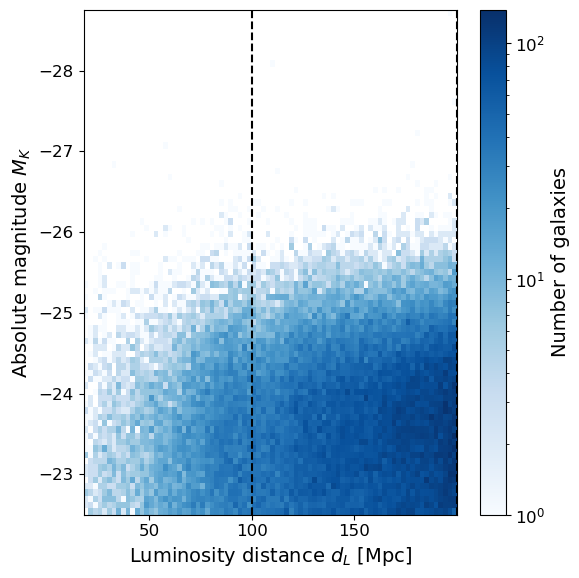

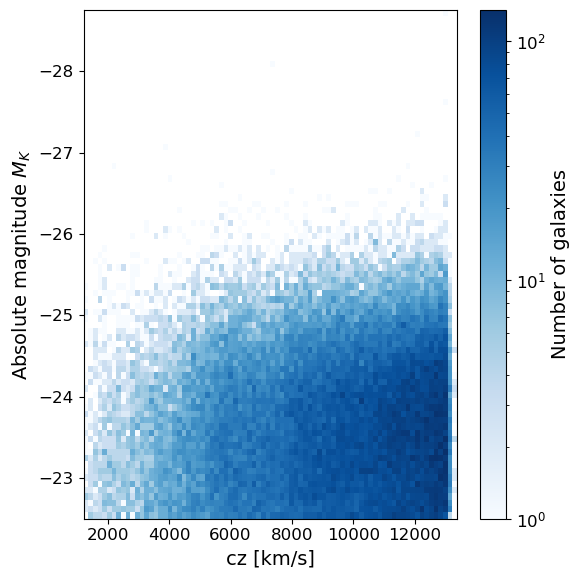


=== Dipole for Full Sample ===
N = 78919 galaxies
Equatorial RA = 104.00°  Dec = 50.97°
Galactic l = 165.49°  b = 21.43°  (boot errs l,b = 3.19,3.35 deg)
Amplitude = 0.0498 ± 0.0026
Angular separation from Auger = 75.05° ± 2.97°

=== Dipole for 1500-2000 km/s ===
N = 327 galaxies
Equatorial RA = 100.14°  Dec = -48.40°
Galactic l = 257.41°  b = -21.65°  (boot errs l,b = 7.84,11.06 deg)
Amplitude = 0.2712 ± 0.0413
Angular separation from Auger = 24.40° ± 6.76°

=== Dipole for 2000-2500 km/s ===
N = 427 galaxies
Equatorial RA = 156.40°  Dec = -18.45°
Galactic l = 261.08°  b = 32.32°  (boot errs l,b = 5.39,8.95 deg)
Amplitude = 0.3453 ± 0.0350
Angular separation from Auger = 52.53° ± 7.98°

=== Dipole for 2500-3000 km/s ===
N = 511 galaxies
Equatorial RA = 188.40°  Dec = -25.15°
Galactic l = 297.84°  b = 37.55°  (boot errs l,b = 5.71,5.75 deg)
Amplitude = 0.3506 ± 0.0300
Angular separation from Auger = 78.70° ± 4.51°

=== Dipole for 3000-3500 km/s ===
N = 734 galaxies
Equatorial RA = 164.

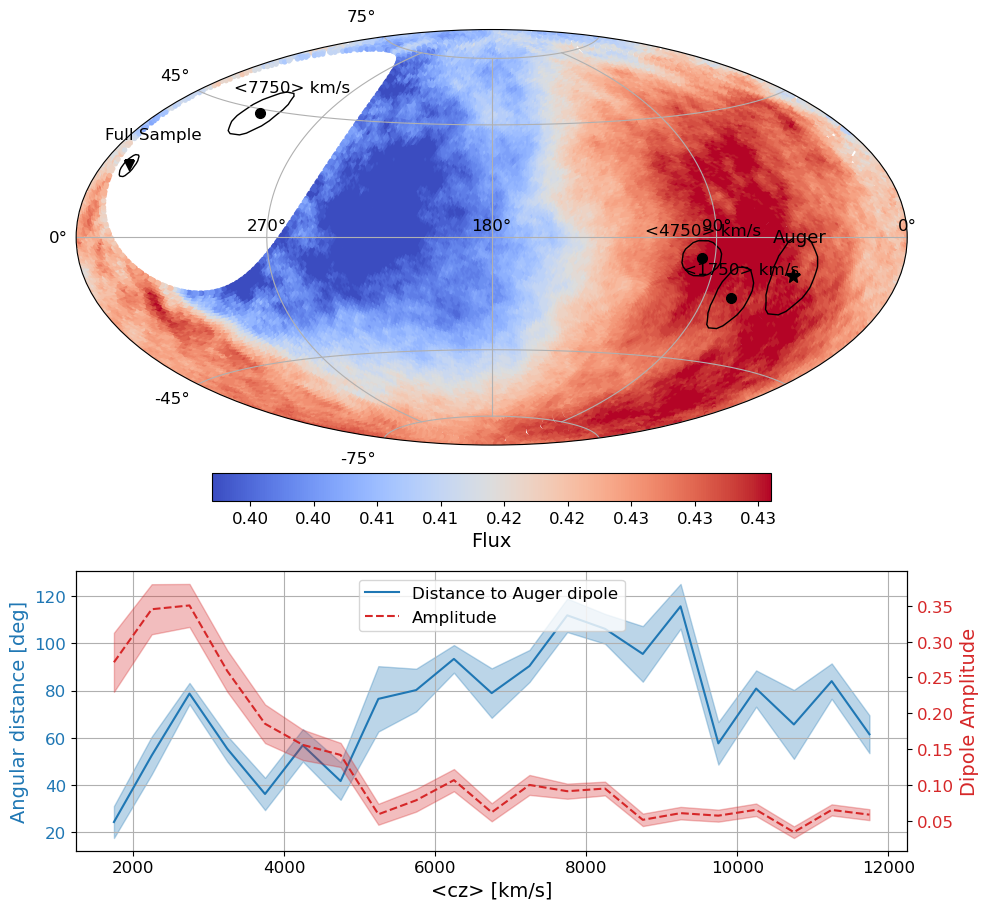

In [25]:
def dipoles_plot_galactic(df, plotname=None, mag_z_plot=True):
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import Planck18
    from matplotlib.patches import Ellipse
    from matplotlib.ticker import FormatStrFormatter

    cosmo = Planck18

    if mag_z_plot:
        try:
            plot_MK_vs_dL(df)
            plot_MK_vs_cz(df)
        except Exception:
            pass

    # ---- galaxy positions / weights (equatorial -> will convert to galactic) ----
    RA_all = np.deg2rad(df['RA'].values)
    Dec_all = np.deg2rad(df['Dec'].values)
    cz_all = df['cz'].values
    weights_all = 10**(-.4 * df['M_K'].values)

    # === Load flux catalogue ===
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)
    # expected columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    # If file actually contains galactic columns (col 4,5) use them:
    if flux_cat.shape[1] >= 6:
        flux_l = flux_cat[:, 4]
        flux_b = flux_cat[:, 5]
    else:
        # fallback: compute from RA/Dec present in file
        flux_ra = flux_cat[:, 1]
        flux_dec = flux_cat[:, 0]
        scf = SkyCoord(ra=flux_ra * u.deg, dec=flux_dec * u.deg, frame='icrs')
        galf = scf.transform_to('galactic')
        flux_l = galf.l.deg
        flux_b = galf.b.deg

    flux_val = flux_cat[:, 2]
    # remove NaNs in flux
    mask_flux = np.isfinite(flux_val) & np.isfinite(flux_l) & np.isfinite(flux_b)
    flux_val = flux_val[mask_flux]
    flux_l = flux_l[mask_flux]
    flux_b = flux_b[mask_flux]

    # === cz bins ===
    cz_i, cz_f, cz_step = 1500, 12000, 500
    cz_bins = [(cz, cz + cz_step) for cz in range(cz_i, cz_f, cz_step)]
    cz_bins.insert(0, (cz_i, cz_f))  # full sample first

    dipole_results = {}
    cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
    cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))
    cmap = cm.cividis

    # === Auger reference dipole (equatorial -> galactic) ===
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_icrs = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    auger_g = auger_icrs.transform_to('galactic')
    auger_l_deg = auger_g.l.deg
    auger_b_deg = auger_g.b.deg
    auger_error_ra_deg = 10.0
    auger_error_dec_deg = 13.0

    # === Loop through bins, compute dipoles (unchanged math), convert dipole -> galactic for plotting ===
    for i, (cz_min, cz_max) in enumerate(cz_bins):
        label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
        cz_mid = 0.5 * (cz_min + cz_max)
        color = 'k' if i == 0 else cmap(cz_norm(cz_mid))

        mask = (cz_all > cz_min) & (cz_all < cz_max)
        RA = RA_all[mask]
        Dec = Dec_all[mask]
        weights = weights_all[mask]

        if len(RA) < 10:
            print(f"Skipping {label} — too few galaxies ({len(RA)})")
            continue

        W = np.sum(weights)

        # 2D Rayleigh (over RA) kept for legacy info
        a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
        b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
        r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)

        # 3D dipole in equatorial unit vectors
        x = np.cos(Dec) * np.cos(RA)
        y = np.cos(Dec) * np.sin(RA)
        z = np.sin(Dec)
        X = np.sum(weights * x)
        Y = np.sum(weights * y)
        Z = np.sum(weights * z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        Xn, Yn, Zn = X / norm, Y / norm, Z / norm

        dipole_amp = norm / W
        alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
        delta_d = np.degrees(np.arcsin(np.clip(Z / norm, -1, 1)))

        # uncertainties / significance (unchanged)
        Weff = W**2 / np.sum(weights**2)
        sigma_r = np.sqrt(2 / Weff)
        sigma_phi_deg = np.rad2deg(sigma_r / r_alpha) if r_alpha > 0 else 0.0
        sigma_dec_deg = sigma_phi_deg
        P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
        Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh) if P_rayleigh < 0.5 else 0.0

        # dipole direction: build SkyCoord in ICRS then transform to galactic for plotting
        dip_icrs = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
        dip_gal = dip_icrs.transform_to('galactic')
        l_d = dip_gal.l.deg
        b_d = dip_gal.b.deg

        # angular separation with Auger (use ICRS separation as before)
        separation = dip_icrs.separation(auger_icrs).deg

        dipole_results[label] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'l': l_d,
            'b': b_d,
            'r_alpha': r_alpha,
            'd_perp': dipole_amp,
            'sigma_r': sigma_r,
            'sigma_phi': sigma_phi_deg,
            'sigma_dec': sigma_dec_deg,
            'Z': Zsig,
            'P': P_rayleigh,
            'separation': separation,
            'N': len(RA),
            'color': color
        }

        # --- bootstrap uncertainties (same approach) ---
        n_bootstrap = 500
        dipole_ls = []
        dipole_bs_bs = []
        amps_bs = []
        sep_bs = []
        for _ in range(n_bootstrap):
            idx = np.random.choice(len(RA), size=len(RA), replace=True)
            RA_bs = RA[idx]
            Dec_bs = Dec[idx]
            w_bs = weights[idx]

            x = np.cos(Dec_bs) * np.cos(RA_bs)
            y = np.cos(Dec_bs) * np.sin(RA_bs)
            z = np.sin(Dec_bs)

            Xb = np.sum(w_bs * x)
            Yb = np.sum(w_bs * y)
            Zb = np.sum(w_bs * z)
            normb = np.sqrt(Xb**2 + Yb**2 + Zb**2)
            if normb == 0:
                continue
            Xbn, Ybn, Zbn = Xb / normb, Yb / normb, Zb / normb

            amp_b = normb / np.sum(w_bs)
            ra_b = (np.arctan2(Yb, Xb) % (2 * np.pi)) * 180 / np.pi
            dec_b = np.degrees(np.arcsin(np.clip(Zb / normb, -1, 1)))
            dip_icrs_b = SkyCoord(ra=ra_b * u.deg, dec=dec_b * u.deg, frame='icrs')
            dip_gal_b = dip_icrs_b.transform_to('galactic')
            l_b = dip_gal_b.l.deg
            b_b = dip_gal_b.b.deg

            dipole_ls.append(l_b)
            dipole_bs_bs.append(b_b)
            amps_bs.append(amp_b)
            sep_bs.append(dip_icrs_b.separation(auger_icrs).deg)

        sigma_l_boot = np.std(dipole_ls) if dipole_ls else 0.0
        sigma_b_boot = np.std(dipole_bs_bs) if dipole_bs_bs else 0.0
        sigma_amp_boot = np.std(amps_bs) if amps_bs else 0.0
        sigma_sep_boot = np.std(sep_bs) if sep_bs else 0.0

        dipole_results[label].update({
            'sigma_l_boot': sigma_l_boot,
            'sigma_b_boot': sigma_b_boot,
            'sigma_amp_boot': sigma_amp_boot,
            'sigma_sep_boot': sigma_sep_boot
        })

        # Print (brief)
        print(f"\n=== Dipole for {label} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"Equatorial RA = {alpha_d:.2f}°  Dec = {delta_d:.2f}°")
        print(f"Galactic l = {l_d:.2f}°  b = {b_d:.2f}°  (boot errs l,b = {sigma_l_boot:.2f},{sigma_b_boot:.2f} deg)")
        print(f"Amplitude = {dipole_amp:.4f} ± {sigma_amp_boot:.4f}")
        print(f"Angular separation from Auger = {separation:.2f}° ± {sigma_sep_boot:.2f}°")

    # === Plotting: top = Hammer (galactic l,b), bottom = dipole amplitude / separation vs cz ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    # configure longitude tick labels (galactic longitudes)
    xticks_deg = [0, 90, 180, 270]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # ---- plot flux in galactic coords ----
    # convert galactic l to radians and wrap for plotting like the RA earlier
    l_rad = np.radians(flux_l)
    b_rad = np.radians(flux_b)
    #l_shift = np.remainder(l_rad, 2 * np.pi)
    #l_shift[l_shift > np.pi] -= 2 * np.pi
    #l_plot = -l_shift  # make longitudes increase leftward (matches earlier RA behaviour)
    #l_plot = -l_rad+np.pi
    l_plot = -((l_rad + np.pi) % (2 * np.pi) - np.pi)

    norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax_top.scatter(l_plot, b_rad, c=flux_val, s=15, cmap='coolwarm', norm=norm_flux, edgecolor='none')
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=.05, fraction=0.05)
    cbar_flux.set_label("Flux")
    cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ---- plot dipoles (only selected bins like original code) ----
    selected_labels = [f"{1500}-{2000} km/s", f"{4500}-{5000} km/s", f"{7500}-{8000} km/s", "Full Sample"]
    for label, res in dipole_results.items():
        if label not in selected_labels:
            continue

        l_rad = np.deg2rad(res['l'])
        b_rad = np.deg2rad(res['b'])
        l_plot = -((l_rad + np.pi) % (2 * np.pi) - np.pi)

        color = res['color']
        marker = 'o' if label != 'Full Sample' else 'v'
        ax_top.plot(l_plot, b_rad, marker, color='k', label=label, markersize=7)

        ellipse = Ellipse(
            (l_plot, b_rad),
            width=2*np.deg2rad(res.get('sigma_l_boot', 1.0)),
            height=2*np.deg2rad(res.get('sigma_b_boot', 1.0)),
            angle=0,
            edgecolor='k',
            facecolor='none',
            alpha=1,
            transform=ax_top.transData
        )
        ax_top.add_patch(ellipse)

        czmid = float(label.split('-')[0]) + 250 if label != 'Full Sample' else label
        ax_top.text(l_plot, b_rad + 0.15, f'<{int(czmid)}> km/s' if czmid != 'Full Sample' else 'Full Sample', ha='center', color='k', size=12)

    # Auger point (already converted to galactic)
    aug_l_rad = np.deg2rad(auger_l_deg)
    aug_b_rad = np.deg2rad(auger_b_deg)
    aug_l_plot = -((aug_l_rad + np.pi) % (2 * np.pi) - np.pi)

    ax_top.plot(aug_l_plot, aug_b_rad, 'k*', markersize=10, label='Auger Dipole')
    aug_ell = Ellipse(
        (aug_l_plot, aug_b_rad),
        width=2*np.deg2rad(auger_error_ra_deg),
        height=2*np.deg2rad(auger_error_dec_deg),
        angle=0,
        edgecolor='k',
        facecolor='none',
        alpha=1,
        transform=ax_top.transData
    )
    ax_top.add_patch(aug_ell)
    ax_top.text(aug_l_plot, aug_b_rad + 0.2, "Auger", ha='center', color='k', size=13)

    # === Bottom plot: separation and amplitude vs cz (same as before) ===
    cz_bin_centers = []
    angular_separations = []
    dipole_amps = []
    ang_diam_dists = []
    for label, res in dipole_results.items():
        if label == "Full Sample":
            continue
        cz_mid = float(label.split('-')[0]) + cz_step/2
        cz_bin_centers.append(cz_mid)
        angular_separations.append(res['separation'])
        dipole_amps.append(res['d_perp'])

        z = cz_mid / 3e5
        d_ang = cosmo.angular_diameter_distance(z).value
        ang_diam_dists.append(d_ang)

    x = cz_bin_centers
    sep_errors = [dipole_results[label].get('sigma_sep_boot', 0.0) for label in dipole_results if label != "Full Sample"]
    amp_errors = [dipole_results[label].get('sigma_amp_boot', 0.0) for label in dipole_results if label != "Full Sample"]

    color1 = 'C0'
    ax_bottom.fill_between(x, np.array(angular_separations)-np.array(sep_errors), np.array(angular_separations)+np.array(sep_errors), color=color1, alpha=0.3)
    ln1 = ax_bottom.plot(x, angular_separations, ls='-', color=color1, label='Distance to Auger dipole')
    ax_bottom.set_ylabel("Angular distance [deg]", color=color1)
    ax_bottom.tick_params(axis='y', labelcolor=color1)
    ax_bottom.grid(True)

    ax2 = ax_bottom.twinx()
    color2 = 'C3'
    ax2.fill_between(x, np.array(dipole_amps)-np.array(amp_errors), np.array(dipole_amps)+np.array(amp_errors), color=color2, alpha=0.3)
    ln2 = ax2.plot(x, dipole_amps, ls='--', color=color2, label='Amplitude')
    ax2.set_ylabel("Dipole Amplitude", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax_bottom.set_xlabel("<cz> [km/s]")

    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax_bottom.legend(lines, labels, loc='upper center')

    plt.tight_layout()
    if plotname: plt.savefig(plotname, dpi=300)
    plt.show()

df_K = df[df['M_K']<-22.5]
df_K_dec = df_K[df_K['Dec']<45]
dipoles_plot_galactic(df_K)